<h1 style="text-align: center;">Non Donor Analysis</h1>

## ===============================================================================================================

## Finding best features to make reduce the cost of conversion from non-donor to active-donor 

### ===============================================================================================================

### Import Dependancies 

#### Import Python Dependancies

In [1]:
# Python Dependencies
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


#### Initialize the PySpark  

In [2]:
# Import findspark and initialize. 
import findspark
findspark.init()

#### Import PySpark Packages

In [3]:
# Import packages
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date,when
from pyspark.sql import functions as F
import time

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

## Read data and data types 

#### Read data from the CSV file

In [4]:
# Store filepath in a variable
constituents_path = Path("./Resources/constituents.csv")
# 1. Read CSV file 
constituents_df = spark.read.csv(str(constituents_path), sep=",", header=True)
# Show the dataframe

#### Display the available columns in the dataframe

In [5]:
constituents_df.columns

['ConstituentID',
 'City',
 'State',
 'Postcode',
 'Country',
 'Constituent type',
 'Constituent codes',
 'Lifetime giving',
 'First gift amount',
 'First gift type',
 'First gift date',
 'First gift fund',
 'Latest gift amount',
 'Latest gift type',
 'Latest gift date',
 'Latest gift fund',
 'Greatest gift amount',
 'Greatest gift type',
 'Greatest gift date',
 'Greatest gift fund',
 'Birthdate',
 'Age',
 'AgeInMonths',
 'PrimaryEmployment',
 'Education',
 'Gender',
 'Marital status',
 'Solicit codes',
 'Student Organizations',
 'Arts',
 'Fraternal Organizations',
 "Men's Athletics",
 'Scholarship Recipient',
 "Women's Athletics"]

#### Display the datatypes of the columns

In [6]:
constituents_df.printSchema()

root
 |-- ConstituentID: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Postcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Constituent type: string (nullable = true)
 |-- Constituent codes: string (nullable = true)
 |-- Lifetime giving: string (nullable = true)
 |-- First gift amount: string (nullable = true)
 |-- First gift type: string (nullable = true)
 |-- First gift date: string (nullable = true)
 |-- First gift fund: string (nullable = true)
 |-- Latest gift amount: string (nullable = true)
 |-- Latest gift type: string (nullable = true)
 |-- Latest gift date: string (nullable = true)
 |-- Latest gift fund: string (nullable = true)
 |-- Greatest gift amount: string (nullable = true)
 |-- Greatest gift type: string (nullable = true)
 |-- Greatest gift date: string (nullable = true)
 |-- Greatest gift fund: string (nullable = true)
 |-- Birthdate: string (nullable = true)
 |-- Age: string (nullable 

## Preprocessing data

#### Change data types of the numerical data points

In [7]:
#Change amounts coulumns to decimals 
constituents_df = constituents_df.withColumn("Lifetime giving", col("Lifetime giving").cast("decimal"))
constituents_df = constituents_df.withColumn("First gift amount", col("First gift amount").cast("decimal"))
onstituents_df = constituents_df.withColumn("Latest gift amount", col("Latest gift amount").cast("decimal"))
constituents_df = constituents_df.withColumn("Greatest gift amount", col("Greatest gift amount").cast("decimal"))
# Change to date format
#constituents_df = constituents_df.withColumn("First gift date", to_date(col("First gift date"), "MM-dd-yyyy"))
#constituents_df = constituents_df.withColumn("Latest gift date", to_date(col("Latest gift date"), "MM-dd-yyyy"))
#constituents_df = constituents_df.withColumn("Greatest gift date", to_date(col("Greatest gift date"), "MM-dd-yyyy"))

### Add new columns to identify the active and repeated donors

In [8]:
#Add new column for repeated constituents
constituents_df = constituents_df.withColumn('repeatedConstituents', when(col('Lifetime giving') > col('First gift amount'), 1).otherwise(0))
#Add a new columns to maintain the active donor status 
constituents_df = constituents_df.withColumn('activeDoner', when(col('First gift amount') > 0, 1).otherwise(0))

# Extract the ZIP code (before the hyphen) and create a new column 'ZipCode'
constituents_df = constituents_df.withColumn("ZipCode", F.split(constituents_df["Postcode"], "-").getItem(0))
#Create a new column for Constituent codes
# Extract the text before the first "(" and create a new column 'Constituent_Code'
constituents_df = constituents_df.withColumn("ConstituentCode", F.split(constituents_df["Constituent codes"], "\\(").getItem(0))

#### Reduce the cardinality of the data by converting discrete data in to the categorical  

In [9]:
#Convert discrete data in to the categorical 
# Create a new column 'FirstgiftBlock' based on the conditions
constituents_df = constituents_df.withColumn(
    "FirstgiftBlock",
    F.when((F.col("First gift amount").isNull()) | (F.col("First gift amount") == 0), "0-0")
    .when((F.col("First gift amount") > 0) & (F.col("First gift amount") <= 10), "0-10")
    .when((F.col("First gift amount") > 10) & (F.col("First gift amount") <= 50), "11-50")
    .when((F.col("First gift amount") > 50) & (F.col("First gift amount") <= 100), "51-100")
    .when((F.col("First gift amount") > 100) & (F.col("First gift amount") <= 500), "101-500")
    .when((F.col("First gift amount") > 500) & (F.col("First gift amount") <= 1000), "501-1000")
    .when((F.col("First gift amount") > 1000) & (F.col("First gift amount") <= 5000), "1001-5000")
    .when((F.col("First gift amount") > 5000) & (F.col("First gift amount") <= 10000), "5001-10000")
    .otherwise("Over 10000")
)

# Create a new column 'LifetimegivingBlock' based on the conditions
constituents_df = constituents_df.withColumn(
    "LifetimegivingBlock",
    F.when((F.col("Lifetime giving").isNull()) | (F.col("Lifetime giving") == 0), "0-0")
    .when((F.col("Lifetime giving") > 0) & (F.col("Lifetime giving") <= 10), "0-10")
    .when((F.col("Lifetime giving") > 10) & (F.col("Lifetime giving") <= 50), "11-50")
    .when((F.col("Lifetime giving") > 50) & (F.col("Lifetime giving") <= 100), "51-100")
    .when((F.col("Lifetime giving") > 100) & (F.col("Lifetime giving") <= 500), "101-500")
    .when((F.col("Lifetime giving") > 500) & (F.col("Lifetime giving") <= 1000), "501-1000")
    .when((F.col("Lifetime giving") > 1000) & (F.col("Lifetime giving") <= 5000), "1001-5000")
    .when((F.col("Lifetime giving") > 5000) & (F.col("Lifetime giving") <= 10000), "5001-10000")
    .otherwise("Over 10000")
)


# Create a new column 'AgeBlock' based on the conditions
constituents_df = constituents_df.withColumn(
    "AgeBlock",
    F.when((F.col("Age").isNull()) | (F.col("Age") == 0), "0-0")
    .when((F.col("Age") > 0) & (F.col("Age") <= 20), "0-20")
    .when((F.col("Age") > 20) & (F.col("Age") <= 30), "21-30")
    .when((F.col("Age") > 30) & (F.col("Age") <= 40), "31-40")
    .when((F.col("Age") > 40) & (F.col("Age") <= 50), "41-50")
    .when((F.col("Age") > 50) & (F.col("Age") <= 60), "51-60")
    .when((F.col("Age") > 60) & (F.col("Age") <= 70), "61-70")
    .when((F.col("Age") > 70) & (F.col("Age") <= 80), "71-80")
    .otherwise("Over 80")
)

## Find the summary of the dataset

In [10]:
#Create a temporary view of the DataFrame.
constituents_df.createOrReplaceTempView('constituents')

#### Summary of active, inactive and repeated donors of the dataset

In [11]:
#Counts at a glance and see the potential donor counts 
result_df =spark.sql("""
    SELECT 
        COUNT(CASE WHEN `activeDoner`=1  THEN ConstituentID END) AS activeConstituent,
        COUNT(CASE WHEN `First gift amount` IS NULL THEN ConstituentID END) AS potentialConstituent,
        COUNT(CASE WHEN `repeatedConstituents`=1 THEN ConstituentID END) AS repeatedConstituent
       
    FROM 
        constituents 
  
""")
# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
result_pandas_df = result_df.toPandas()

result_pandas_df.fillna(0, inplace=True)
result_pandas_df.head()

,activeConstituent,potentialConstituent,repeatedConstituent
0,11462,39451,4358


#### Graphical view of the summary data 

Text(0.5, 1.0, 'Constituent Distribution')

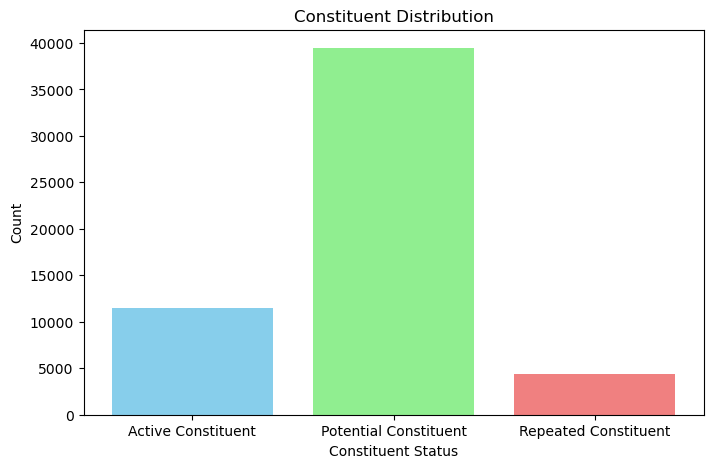

In [12]:
# Create a bar chart based on the data

# Extract the relevant data from existing DataFrame
categories = ['Active Constituent', 'Potential Constituent', 'Repeated Constituent']
values = [
    result_pandas_df['activeConstituent'][0], 
    result_pandas_df['potentialConstituent'][0], 
    result_pandas_df['repeatedConstituent'][0]
     ]

# Plot the bar graph
plt.figure(figsize=(8, 5))  # Set figure size
plt.bar(categories, values, color=['skyblue', 'lightgreen', 'lightcoral'])

# Add labels and title
plt.xlabel('Constituent Status')
plt.ylabel('Count')
plt.title('Constituent Distribution')

# Show the plot

## Further cleaning of the data set 

#### Finding the data columns that having more empty data

In [13]:
# Find the total number of rows in the DataFrame
total_rows = constituents_df.count()

# Create a list of columns to check for NULLs
columns = constituents_df.columns

# Create an expression for each column to count NULLs
null_counts = [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in columns]

# Use the select and agg functions to count NULLs for each column
null_counts_df = constituents_df.select(null_counts)

# Convert to Pandas DataFrame
null_counts_df_panda = null_counts_df.toPandas()

# Pivot the DataFrame using pd.melt to display the null counts row-wise
null_counts_df_panda_melted = pd.melt(null_counts_df_panda, var_name='Column', value_name='Null_Count')

# Calculate the percentage of null values
null_counts_df_panda_melted['Null_Percentage'] = (null_counts_df_panda_melted['Null_Count'] / total_rows) * 100

# Sort the DataFrame by 'Null_Count' in descending order
null_counts_df_panda_melted_sorted = null_counts_df_panda_melted.sort_values(by='Null_Count', ascending=False)

# Show the result
null_counts_df_panda_melted_sorted.head(10)


,Column,Null_Count,Null_Percentage
22,AgeInMonths,50909,99.992143
29,Arts,50120,98.442441
33,Women's Athletics,49314,96.859348
30,Fraternal Organizations,49088,96.415454
28,Student Organizations,48785,95.820321
31,Men's Athletics,48342,94.950209
32,Scholarship Recipient,44434,87.274370
27,Solicit codes,44367,87.142773
23,PrimaryEmployment,41070,80.667020
16,Greatest gift amount,39890,78.349341


#### Drop the data columns that having more than 80% null datapoints 

In [14]:
#Drop the columns those having more null values 
constituents_df=constituents_df.drop("AgeInMonths","Arts","Women's Athletics","Fraternal Organizations","Fraternal Organizations","Student Organizations")
constituents_df=constituents_df.drop( "Men's Athletics","Scholarship Recipient","Solicit codes","PrimaryEmployment") 
#Drop Constituent ID and Country columns
constituents_df=constituents_df.drop( "ConstituentID","Country","repeatedConstituents","Postcode","Constituent codes","Birthdate","First gift amount","Lifetime giving","Age") 
#constituents_df.show()
      

#### Convert PySpark dataframe to pandas dataframe for further cleaning

In [15]:
#Convert to Pandas dataframe
constituents_pd_df = constituents_df.toPandas()
constituents_pd_df.head()

,City,State,Constituent type,First gift type,First gift date,First gift fund,Latest gift amount,Latest gift type,Latest gift date,Latest gift fund,...,Greatest gift fund,Education,Gender,Marital status,activeDoner,ZipCode,ConstituentCode,FirstgiftBlock,LifetimegivingBlock,AgeBlock
0,Superior,WI,Organization,None,None,None,None,None,None,None,...,None,None,None,None,0,54880,Business,0-0,0-0,0-0
1,Hermantown,MN,Organization,One-time gift,8/29/2012,Women's Cross Country Fund,50,One-time gift,8/29/2012,Women's Cross Country Fund,...,Women's Cross Country Fund,None,None,None,1,55811,Other Organizations,11-50,11-50,0-0
2,Esko,MN,Organization,One-time gift,4/29/2019,VNSC Emergency Fund,50,One-time gift,4/29/2019,VNSC Emergency Fund,...,VNSC Emergency Fund,None,None,None,1,55733,Other Organizations,11-50,11-50,0-0
3,None,None,Organization,One-time gift,9/10/1985,0-Richard I Bong Memorial Scholarship,25,One-time gift,9/10/1985,0-Richard I Bong Memorial Scholarship,...,0-Richard I Bong Memorial Scholarship,None,None,None,1,None,Business,11-50,11-50,0-0
4,Superior,WI,Organization,None,None,None,None,None,None,None,...,None,None,None,None,0,54880,Business,0-0,0-0,0-0


In [16]:
constituents_pd_df.columns

Index(['City', 'State', 'Constituent type', 'First gift type',
       'First gift date', 'First gift fund', 'Latest gift amount',
       'Latest gift type', 'Latest gift date', 'Latest gift fund',
       'Greatest gift amount', 'Greatest gift type', 'Greatest gift date',
       'Greatest gift fund', 'Education', 'Gender', 'Marital status',
       'activeDoner', 'ZipCode', 'ConstituentCode', 'FirstgiftBlock',
       'LifetimegivingBlock', 'AgeBlock'],
      dtype='object')

#### Select only the demographic data and gift amounts for the rest of the analysis.

In [17]:
#Create a new dataframe for only for the selected attributes
selected_columns = ['State', 'ZipCode', 'ConstituentCode','First gift type' ,'First gift fund','FirstgiftBlock','AgeBlock','Gender','Marital status','activeDoner']

# Create a new DataFrame for active donors with only the selected columns
clean_donors_df = constituents_pd_df[selected_columns]

# Show the first few rows of the active donors DataFrame
clean_donors_df.head()

,State,ZipCode,ConstituentCode,First gift type,First gift fund,FirstgiftBlock,AgeBlock,Gender,Marital status,activeDoner
0,WI,54880,Business,None,None,0-0,0-0,None,None,0
1,MN,55811,Other Organizations,One-time gift,Women's Cross Country Fund,11-50,0-0,None,None,1
2,MN,55733,Other Organizations,One-time gift,VNSC Emergency Fund,11-50,0-0,None,None,1
3,None,None,Business,One-time gift,0-Richard I Bong Memorial Scholarship,11-50,0-0,None,None,1
4,WI,54880,Business,None,None,0-0,0-0,None,None,0


## Further reducing the cardinality of the dataset (replacing the low frequency data with “other”)

In [18]:
# Look at State value counts to identify and replace with "Other"
value_counts=clean_donors_df['State'].value_counts()
value_counts[value_counts > 1]

State
WI    18573
MN    14766
FL      884
IL      698
CA      666
MI      661
TX      566
AZ      491
CO      342
WA      275
NY      215
IA      212
VA      209
OH      197
PA      187
GA      180
NC      165
MO      163
ND      159
OR      155
IN      140
NV      136
NJ      118
TN      111
AK      105
MD      103
MA       91
SD       90
MT       86
KS       83
ID       78
SC       76
KY       71
NM       68
OK       68
AR       67
NE       66
AL       66
UT       54
CT       41
LA       41
HI       39
WY       37
ME       29
MS       27
NH       26
AE       24
DE       20
WV       16
VT       15
DC       15
RI       14
AP        4
Name: count, dtype: int64

In [19]:
# Choose a cutoff value and create a list of State to be replaced
# use the variable name `State_to_replace`
cutoff_value=100
State_to_replace = value_counts[value_counts < cutoff_value].index

# Replace in dataframe
for cls in State_to_replace:
    clean_donors_df['State'] = clean_donors_df['State'].replace(cls,"Other")

C:\Users\rohan\AppData\Local\Temp\ipykernel_19144\4137844185.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_donors_df['State'] = clean_donors_df['State'].replace(cls,"Other")


In [20]:
# Look at ZipCode value counts to identify and replace with "Other"
value_counts=clean_donors_df['ZipCode'].value_counts()
value_counts[value_counts > 1]

ZipCode
54880    4319
55811    1165
55803     690
55804     652
55720     640
         ... 
80831       2
19116       2
50125       2
69361       2
87048       2
Name: count, Length: 2864, dtype: int64

In [21]:
# Choose a cutoff value and create a list of State to be replaced
# use the variable name `Zip_to_replace`
cutoff_value=100
Zip_to_replace = value_counts[value_counts < cutoff_value].index

# Replace in dataframe
for cls in Zip_to_replace:
    clean_donors_df['ZipCode'] = clean_donors_df['ZipCode'].replace(cls,"Other")

C:\Users\rohan\AppData\Local\Temp\ipykernel_19144\2656486741.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_donors_df['ZipCode'] = clean_donors_df['ZipCode'].replace(cls,"Other")


In [22]:
# Look at ConstituentCode value counts to identify and replace with "Other"
value_counts=clean_donors_df['ConstituentCode'].value_counts()
value_counts[value_counts > 1]

ConstituentCode
Alumni                       26466
Friend                        5653
Attended Didn't Graduate      5472
Parent                        5259
Students                      3640
Former Parent                 1981
Business                      1027
Former Faculty & Staff         503
Faculty/Staff                  447
Retired Faculty/Staff          226
Other Organizations             72
Memorial Donor                  57
School                          50
Foundation                      49
Religious Organizations          8
Matching Gift Company            2
Name: count, dtype: int64

In [23]:
# Choose a cutoff value and create a list of ConstituentCode to be replaced
# use the variable name `ConstituentCode_to_replace`
cutoff_value=20
ConstituentCode_to_replace = value_counts[value_counts < cutoff_value].index

# Replace in dataframe
for cls in ConstituentCode_to_replace:
    clean_donors_df['ConstituentCode'] = clean_donors_df['ConstituentCode'].replace(cls,"Other")

C:\Users\rohan\AppData\Local\Temp\ipykernel_19144\3067329163.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_donors_df['ConstituentCode'] = clean_donors_df['ConstituentCode'].replace(cls,"Other")


In [24]:
# Look at First gift type value counts to identify and replace with "Other"
value_counts=clean_donors_df['First gift type'].value_counts()
value_counts[value_counts > 1]

First gift type
One-time gift                         9309
Pledge                                1429
Soft credit one-time gift              661
Soft credit pledge                     183
Recurring gift payment                  50
Soft credit pledge payment              37
Matching gift pledge                    31
Pledge payment                          26
Other                                   24
Soft credit recurring gift payment       9
Soft credit other                        6
Planned gift                             3
Gift-in-kind                             3
Name: count, dtype: int64

In [25]:
# Look at First gift fund value counts to identify and replace with "Other"
value_counts=clean_donors_df['First gift fund'].value_counts()
value_counts[value_counts > 50]

First gift fund
Superior Fund                                2626
Men's Baseball Fund                           866
Total gifts given prior to 7/1/86             615
Foundation Scholarship Fund                   418
Alumni Association Membership Fund            414
Student Calling Fund                          332
Women's Softball Fund                         326
Women's Basketball Fund                       310
Men's Hockey Fund                             273
Men's Soccer Fund                             270
Women's Volleyball Fund                       269
Men's Basketball Fund                         268
Gigliotti, Tony, Scholarship                  247
Women's Soccer Fund                           232
Alumni Association Fund                       185
Women's Athletics Fund                        184
Track and Cross Country Fund                  168
Athletics Fund-General                        162
Women's Hockey Fund                           146
0-Unassigned For Use In History   

In [26]:
# Choose a cutoff value and create a list of First gift fund to be replaced
# use the variable name `Firstgiftfunde_to_replace`
cutoff_value=50
Firstgiftfunde_to_replace = value_counts[value_counts < cutoff_value].index

# Replace in dataframe
for cls in Firstgiftfunde_to_replace:
    clean_donors_df['First gift fund'] = clean_donors_df['First gift fund'].replace(cls,"Other")

C:\Users\rohan\AppData\Local\Temp\ipykernel_19144\383733602.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_donors_df['First gift fund'] = clean_donors_df['First gift fund'].replace(cls,"Other")


In [27]:
print(clean_donors_df.dtypes)

State              object
ZipCode            object
ConstituentCode    object
First gift type    object
First gift fund    object
FirstgiftBlock     object
AgeBlock           object
Gender             object
Marital status     object
activeDoner         int32
dtype: object


## Create the correlation matrix and finding the features that having high correlation with active donors using Pearson correlation

#### Generate correlation matrix for both demographic and gift amounts features 

In [28]:
#Find out the correlation between features available and active donors 
# Convert categorical data to numeric with `pd.get_dummies`
clean_donors_df_dummy = pd.get_dummies(clean_donors_df)

# Convert any boolean columns (True/False) to integers (1/0)
clean_donors_df_dummy = clean_donors_df_dummy.astype(int)

#Find correlation between activeDoner and other features 
correlation_matrix = clean_donors_df_dummy.corr()

# Display the top 20 correlations with 'activeDoner', dropping NaN values and sorting in descending order
top_20_correlations = correlation_matrix['activeDoner'].dropna().sort_values(ascending=False).head(20)

print(top_20_correlations)

activeDoner                                           1.000000
First gift type_One-time gift                         0.849833
FirstgiftBlock_11-50                                  0.692489
First gift fund_Other                                 0.434020
First gift fund_Superior Fund                         0.424565
ConstituentCode_Friend                                0.389078
FirstgiftBlock_51-100                                 0.384136
FirstgiftBlock_0-10                                   0.336650
FirstgiftBlock_101-500                                0.316629
First gift type_Pledge                                0.306444
Marital status_Married                                0.247831
First gift fund_Men's Baseball Fund                   0.243317
First gift type_Soft credit one-time gift             0.200729
First gift fund_Total gifts given prior to 7/1/86     0.193091
AgeBlock_0-0                                          0.192319
First gift fund_Alumni Association Membership Fund    0

#### Graph the correlation data against the active doner

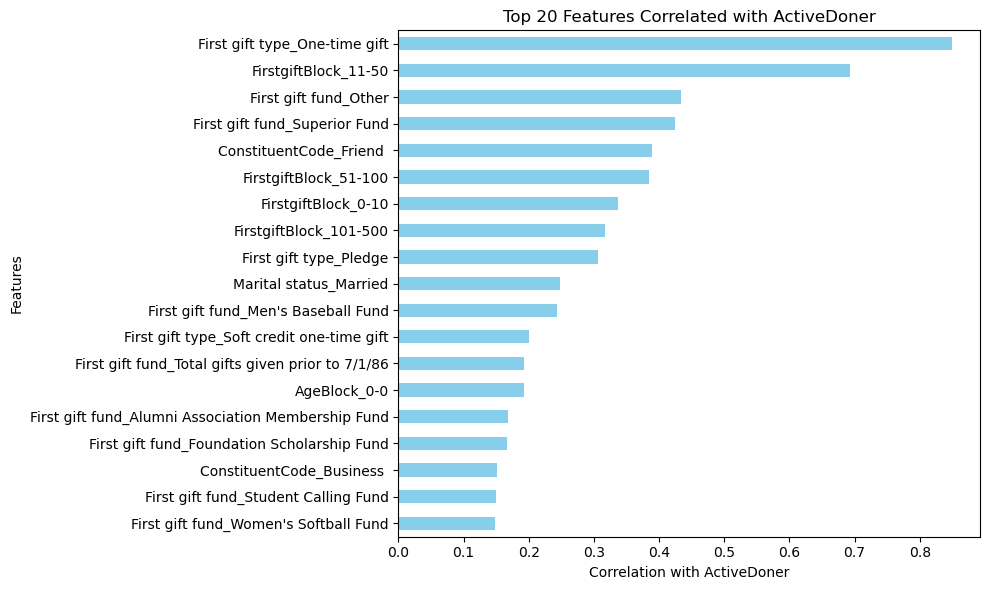

In [29]:
# Remove 'activeDoner' from top 20 correlations 
top_20_correlations_without_activeDoner = top_20_correlations.drop('activeDoner', errors='ignore')

# Plot the updated top 20 correlations without 'activeDoner'
plt.figure(figsize=(10, 6))
top_20_correlations_without_activeDoner.plot(kind='barh', color='skyblue')

# Add labels and title
plt.xlabel('Correlation with ActiveDoner')
plt.ylabel('Features')
plt.title('Top 20 Features Correlated with ActiveDoner')

# Invert the y-axis to display the highest correlation at the top
plt.gca().invert_yaxis()

# Display the plot
plt.tight_layout()
plt.show()


#### Anylyse only the demographic informations. 

In [30]:
#Create a new dataframe for only for the active donors with donor demographic data. 
# List of columns want to use in the new DataFrame
selected_columns = ['State', 'ConstituentCode','AgeBlock','Gender','Marital status','activeDoner']

# Create a new DataFrame for active donors with only the selected columns
clean_donors_demographic_df = constituents_pd_df[selected_columns]

# Show the first few rows of the active donors DataFrame
clean_donors_demographic_df.head()

,State,ConstituentCode,AgeBlock,Gender,Marital status,activeDoner
0,WI,Business,0-0,None,None,0
1,MN,Other Organizations,0-0,None,None,1
2,MN,Other Organizations,0-0,None,None,1
3,None,Business,0-0,None,None,1
4,WI,Business,0-0,None,None,0


#### Generate correlation matrix only for demographic features.

In [31]:
#Find out the correlation between donors demographic features available and active donors 
# Convert categorical data to numeric with `pd.get_dummies`
clean_donors_df_dummy = pd.get_dummies(clean_donors_demographic_df)

# Convert any boolean columns (True/False) to integers (1/0)
clean_donors_df_dummy = clean_donors_df_dummy.astype(int)

#Find correlation between activeDoner and other features 
correlation_matrix = clean_donors_df_dummy.corr()

# Display the top 20 correlations with 'activeDoner', dropping NaN values and sorting in descending order
top_20_correlations = correlation_matrix['activeDoner'].dropna().sort_values(ascending=False).head(20)

print(top_20_correlations)

activeDoner                               1.000000
ConstituentCode_Friend                    0.389078
Marital status_Married                    0.247831
AgeBlock_0-0                              0.192319
ConstituentCode_Business                  0.151793
Marital status_Widowed                    0.114271
ConstituentCode_Retired Faculty/Staff     0.089218
AgeBlock_Over 80                          0.070281
Gender_Male                               0.062237
AgeBlock_71-80                            0.062159
ConstituentCode_Memorial Donor            0.062111
State_WI                                  0.061612
Marital status_Divorced                   0.050472
State_MN                                  0.046401
ConstituentCode_Other Organizations       0.042286
State_CA                                  0.040173
State_FL                                  0.038518
AgeBlock_61-70                            0.034829
State_AZ                                  0.034387
State_VA                       

#### Graph the correlation data against the active doner

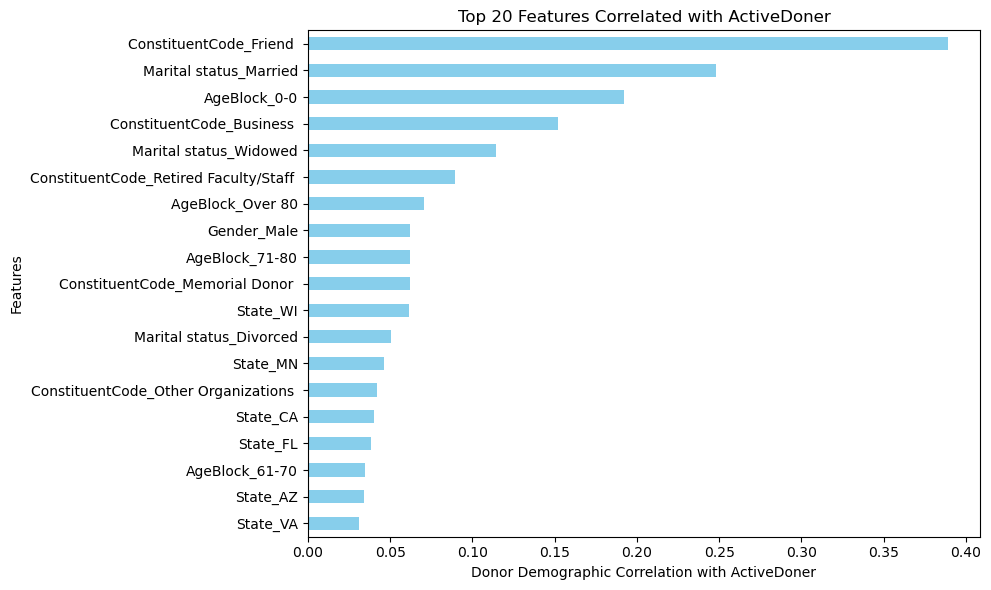

In [32]:
# Remove 'activeDoner' from top 20 correlations 
top_20_correlations_without_activeDoner = top_20_correlations.drop('activeDoner', errors='ignore')

# Plot the updated top 20 correlations without 'activeDoner'
plt.figure(figsize=(10, 6))
top_20_correlations_without_activeDoner.plot(kind='barh', color='skyblue')

# Add labels and title
plt.xlabel('Donor Demographic Correlation with ActiveDoner')
plt.ylabel('Features')
plt.title('Top 20 Features Correlated with ActiveDoner')

# Invert the y-axis to display the highest correlation at the top
plt.gca().invert_yaxis()

# Display the plot
plt.tight_layout()
plt.show()

## Create the correlation matrix using liner regression model. 

#### Import required libraries and build/test/predict the liner model & correlation matrix.. 

In [33]:
# Required imports

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# get a copy of the demographic dataframe
df = clean_donors_demographic_df.copy()

# Selecting features based on correlation analysis
# Adjust the feature list based  correlation analysis
features = ['State','ConstituentCode','AgeBlock','Gender','Marital status']
target = 'activeDoner'

# Encoding categorical features
encoder = OneHotEncoder(drop='first', sparse=False)
X_encoded = pd.DataFrame(encoder.fit_transform(df[features]))
X_encoded.columns = encoder.get_feature_names_out(features)

# Merging encoded features with the target column
X = X_encoded
y = df[target]

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Building the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Model evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# coefficients of the model
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
})
print(coefficients)


C:\Users\rohan\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Accuracy: 0.8322639780018332
              precision    recall  f1-score   support

           0       0.86      0.94      0.90     11799
           1       0.69      0.48      0.56      3475

    accuracy                           0.83     15274
   macro avg       0.77      0.71      0.73     15274
weighted avg       0.82      0.83      0.82     15274

                                              Feature  Coefficient
0                                            State_AK    -0.551521
1                                            State_AL    -0.056995
2                                            State_AP    -0.412590
3                                            State_AR    -0.002712
4                                            State_AZ     0.125185
..                                                ...          ...
87                              Marital status_Single    -1.757569
88  Marital status_UW-Superior,Primary,Social Work...     0.070917
89                             Marital st

C:\Users\rohan\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Graph the positive with high magnitude features.

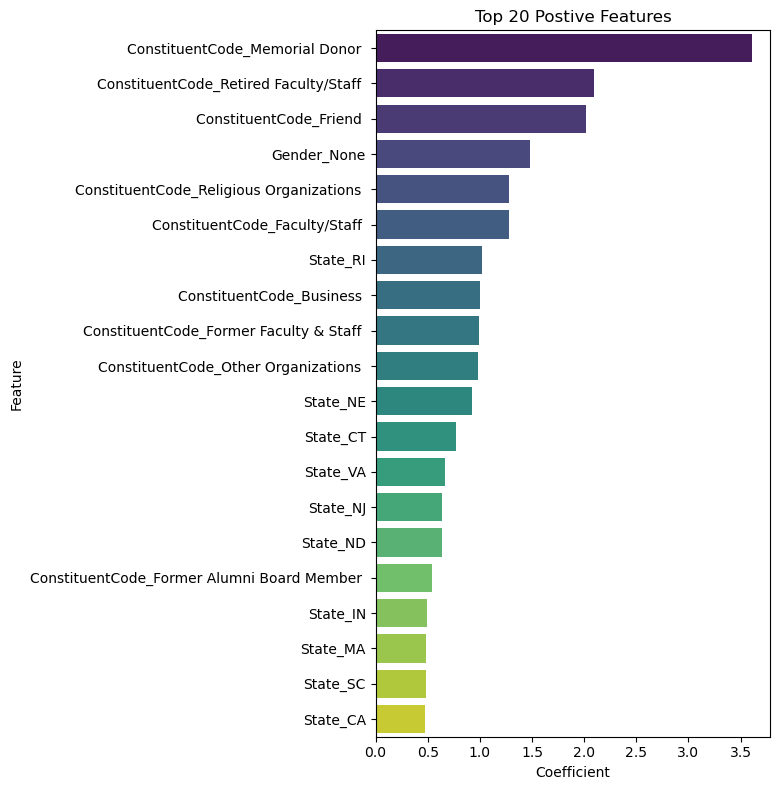

In [45]:
import seaborn as sns

# Sort coefficients in descending order (largest to smallest)
top_20 = coefficients.nlargest(20, 'Coefficient')


# Plotting the horizontal bar graphs
plt.figure(figsize=(12, 8))

# Top 5 features
plt.subplot(1, 2, 1)
sns.barplot(data=top_20, y='Feature', x='Coefficient', palette='viridis')
plt.title('Top 20 Postive Features')
plt.xlabel('Coefficient')
plt.ylabel('Feature')

# Bottom 5 features
#plt.subplot(1, 2, 2)
#sns.barplot(data=bottom_5, y='Feature', x='Coefficient', palette='viridis')
#plt.title('Bottom 5 Features by Coefficient')
#plt.xlabel('Coefficient')
#plt.ylabel('Feature')

plt.tight_layout()
plt.show()


## Visual comparison of most significant data to the active donors. 

#### States data comparison 

In [35]:
#Compare  the active and potential constituent against states and display top 5

result_df =spark.sql("""
    SELECT 
        State,
         COUNT(CASE WHEN `activeDoner`=1 THEN ConstituentID END) AS activeConstituent,
         COUNT(CASE WHEN `activeDoner`=0 THEN ConstituentID END) AS inactiveConstituent
       
    FROM 
        constituents 
    GROUP BY 
        State
    ORDER BY 
        activeConstituent desc
    LIMIT 5
""")
# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
result_pandas_df = result_df.toPandas()

result_pandas_df.fillna(0, inplace=True)
#result_pandas_df['POSTALCODE'] = result_pandas_df['POSTALCODE'].astype(str)
result_pandas_df.head()



,State,activeConstituent,inactiveConstituent
0,WI,4812,13761
1,MN,3772,10994
2,FL,306,578
3,CA,247,419
4,IL,213,485


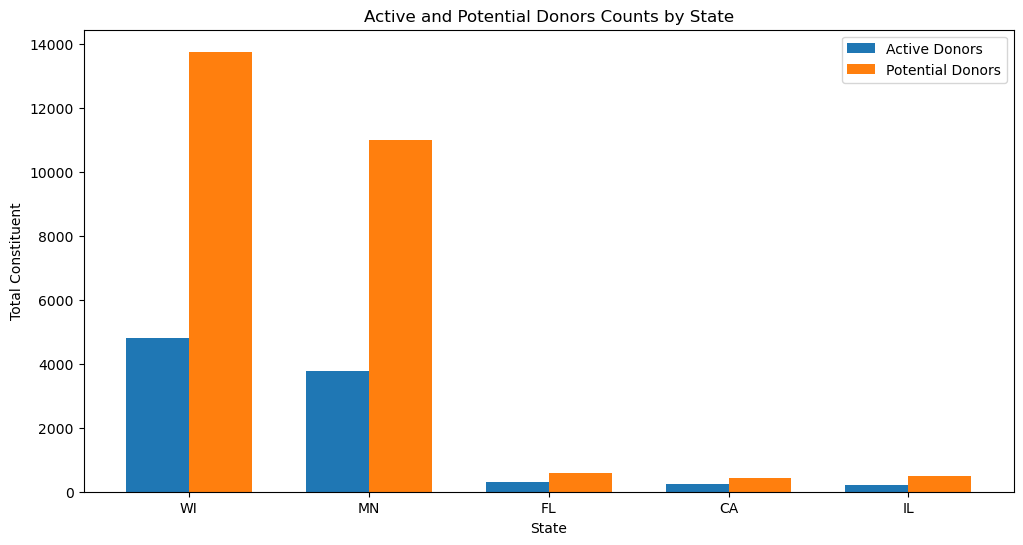

In [36]:
#Plot the data in a barchart 
# Create a bar chart based on the data
# Set the figure size
plt.figure(figsize=(12, 6))

# Define the positions for each bar group
x = np.arange(len(result_pandas_df['State']))  # Label locations
width = 0.35  # Width of the bars

# Plot the bars for active and inactive constituents
plt.bar(x - width/2, result_pandas_df['activeConstituent'], width, label='Active Donors')
plt.bar(x + width/2, result_pandas_df['inactiveConstituent'], width, label='Potential Donors')

# Add labels, title, and legend
plt.xlabel('State')
plt.ylabel('Total Constituent')
plt.title('Active and Potential Donors Counts by State')
plt.xticks(x, result_pandas_df['State'])  # Set the x-ticks to the state names
plt.legend()

# Show the plot
plt.show()

#### Marital data comparison 

In [37]:
#Compare  the active and potential constituent against Marital and display top 5

result_df = spark.sql("""
    SELECT 
        `Marital status`,
        SUM(CASE WHEN activeDoner = 1 THEN 1 ELSE 0 END) as activeConstituent,
        SUM(CASE WHEN activeDoner = 0 THEN 1 ELSE 0 END) as inactiveConstituent
    FROM 
        constituents 
    GROUP BY 
        `Marital status`
    ORDER BY 
        activeConstituent DESC
   LIMIT 5
""")

# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
result_pandas_df = result_df.toPandas()

result_pandas_df.fillna(0, inplace=True)

result_pandas_df.head()

,Marital status,activeConstituent,inactiveConstituent
0,Married,5927,9619
1,0,4682,26341
2,Widowed,420,232
3,Single,291,3107
4,Divorced,118,97


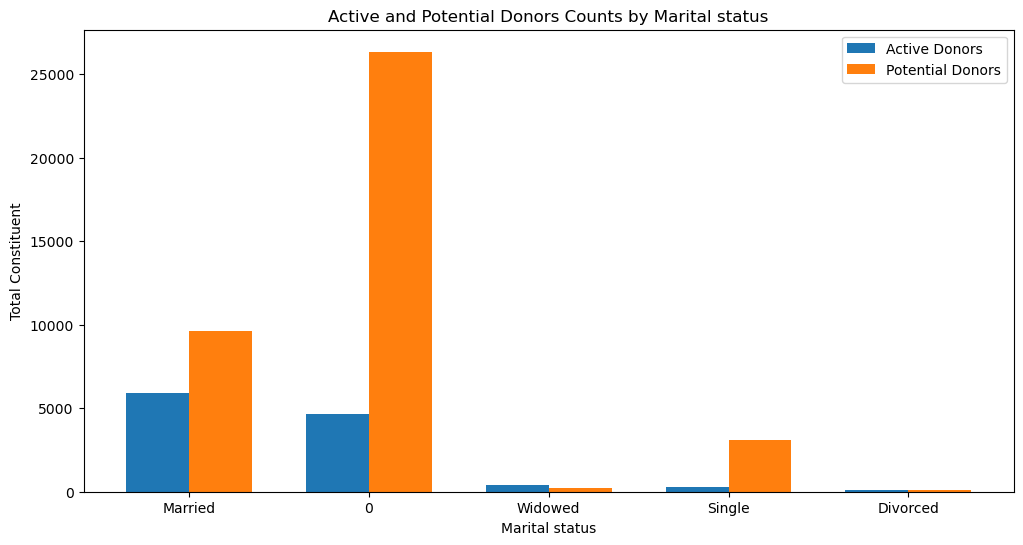

In [38]:
#Plot the data in a barchart 
# Create a bar chart based on the data
# Set the figure size
plt.figure(figsize=(12, 6))

# Define the positions for each bar group
x = np.arange(len(result_pandas_df['Marital status']))  # Label locations
width = 0.35  # Width of the bars

# Plot the bars for active and inactive constituents
plt.bar(x - width/2, result_pandas_df['activeConstituent'], width, label='Active Donors')
plt.bar(x + width/2, result_pandas_df['inactiveConstituent'], width, label='Potential Donors')

# Add labels, title, and legend
plt.xlabel('Marital status')
plt.ylabel('Total Constituent')
plt.title('Active and Potential Donors Counts by Marital status')
plt.xticks(x, result_pandas_df['Marital status'])  # Set the x-ticks to the state names
plt.legend()

# Show the plot
plt.show()

#### Age block data comparison 

In [39]:
#Compare  the active and potential constituent against Age groups and display top 5

result_df = spark.sql("""
    SELECT 
        `AgeBlock`,
        SUM(CASE WHEN activeDoner = 1 THEN 1 ELSE 0 END) as activeConstituent,
        SUM(CASE WHEN activeDoner = 0 THEN 1 ELSE 0 END) as inactiveConstituent
    FROM 
        constituents 
    GROUP BY 
        `AgeBlock`
    ORDER BY 
        activeConstituent DESC
   
""")

# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
result_pandas_df = result_df.toPandas()

result_pandas_df.fillna(0, inplace=True)

result_pandas_df.head()

,AgeBlock,activeConstituent,inactiveConstituent
0,0-0,8401,19889
1,51-60,668,2625
2,61-70,650,1566
3,71-80,597,1024
4,41-50,441,3757


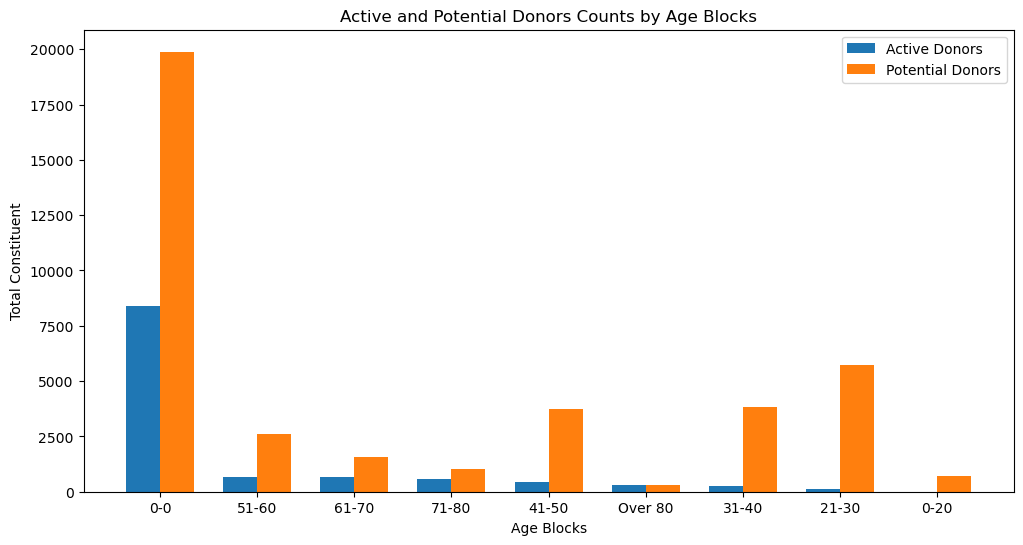

In [40]:
#Plot the data in a barchart 
# Create a bar chart based on the data
# Set the figure size
plt.figure(figsize=(12, 6))

# Define the positions for each bar group
x = np.arange(len(result_pandas_df['AgeBlock']))  # Label locations
width = 0.35  # Width of the bars

# Plot the bars for active and inactive constituents
plt.bar(x - width/2, result_pandas_df['activeConstituent'], width, label='Active Donors')
plt.bar(x + width/2, result_pandas_df['inactiveConstituent'], width, label='Potential Donors')

# Add labels, title, and legend
plt.xlabel('Age Blocks')
plt.ylabel('Total Constituent')
plt.title('Active and Potential Donors Counts by Age Blocks')
plt.xticks(x, result_pandas_df['AgeBlock'])  # Set the x-ticks to the state names
plt.legend()

# Show the plot
plt.show()

#### Constituent code data comparison 

In [41]:
#Compare  the active and potential constituent against Constituent Code  display
result_df = spark.sql("""
    SELECT 
       ConstituentCode,
       SUM(CASE WHEN activeDoner = 1 THEN 1 ELSE 0 END) as activeConstituent,
       SUM(CASE WHEN activeDoner = 0 THEN 1 ELSE 0 END) as inactiveConstituent
    FROM 
        constituents 
    GROUP BY 
        ConstituentCode
    ORDER BY 
        activeConstituent DESC
   LIMIT 5
   
""")
# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
result_pandas_df = result_df.toPandas()

result_pandas_df.fillna(0, inplace=True)

result_pandas_df.head()

,ConstituentCode,activeConstituent,inactiveConstituent
0,Alumni,5411,21055
1,Friend,3872,1781
2,Business,685,342
3,Parent,496,4763
4,Attended Didn't Graduate,287,5185


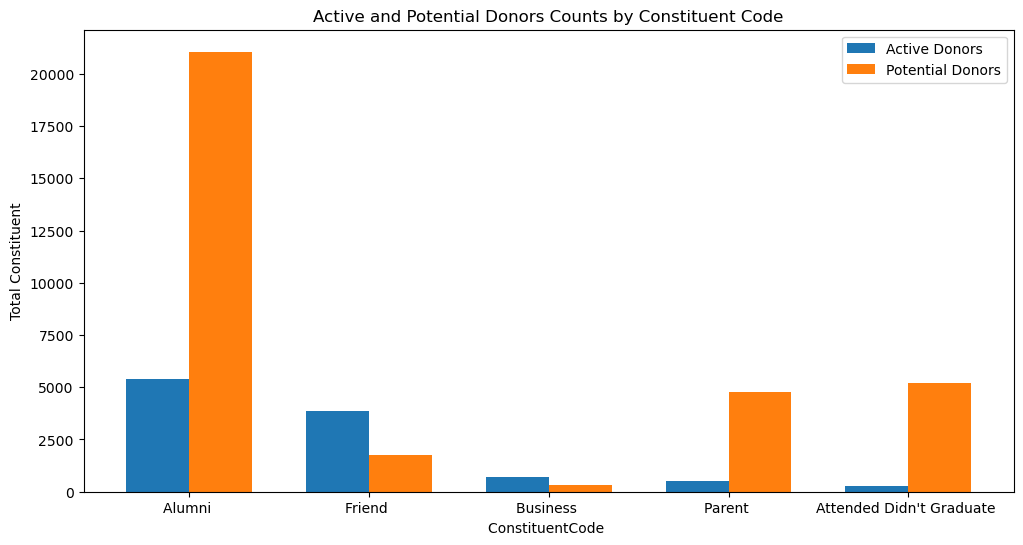

In [42]:
#Plot the data in a barchart 
# Create a bar chart based on the data
# Set the figure size
plt.figure(figsize=(12, 6))

# Define the positions for each bar group
x = np.arange(len(result_pandas_df['ConstituentCode']))  # Label locations
width = 0.35  # Width of the bars

# Plot the bars for active and inactive constituents
plt.bar(x - width/2, result_pandas_df['activeConstituent'], width, label='Active Donors')
plt.bar(x + width/2, result_pandas_df['inactiveConstituent'], width, label='Potential Donors')

# Add labels, title, and legend
plt.xlabel('ConstituentCode ')
plt.ylabel('Total Constituent')
plt.title('Active and Potential Donors Counts by Constituent Code')
plt.xticks(x, result_pandas_df['ConstituentCode'])  # Set the x-ticks to the state names
plt.legend()

# Show the plot
plt.show()

## Writes clean data into the CSV files. 

In [43]:
clean_donors_df.to_csv('./Resources/clean_constituents.csv', index=False)
clean_donors_demographic_df.to_csv('./Resources/clean_demographic_constituents.csv', index=False)